In [86]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn import decomposition, manifold, preprocessing

Function to read the images and convert them to 5D vectors for each pixel:

In [87]:
def readImg(imgPath):
    img = Image.open(imgPath)
    pixels = img.convert('RGB')
    colours = np.array(pixels.getdata()).reshape(img.size + (3,))
    indicesArray = np.moveaxis(np.indices(img.size), 0, 2)
    allArray = np.dstack((indicesArray, colours)).reshape((-1, 5))

    df = pd.DataFrame(allArray, columns = ['y', 'x', 'r', 'g', 'b'])
    df = df[['x', 'y', 'r', 'g', 'b']]  # reorder columns
    return df

In [88]:
images = [os.getcwd() + '/Images/42049_colorBird.jpg', os.getcwd() + '/Images/3096_colorPlane.jpg']  # images are in a dir called Images
bird = readImg(images[0])
plane = readImg(images[1])
print(bird.shape, plane.shape)

(154401, 5) (154401, 5)


Function to normalise the dataframes:

In [89]:
def normalise(df):
    vals = df.values
    scaler = preprocessing.MinMaxScaler()
    scaled = scaler.fit_transform(vals)
    df = pd.DataFrame(scaled, columns = bird.columns)
    return df

In [90]:
bird = normalise(bird)
plane = normalise(plane)

Create a random sample **without** replacement:

In [91]:
def randomSample(df, frac):
    return df.sample(frac = frac, replace = False, random_state = 1)

In [92]:
f = 5000 / bird.shape[0]  # fraction of samples
birdSample = randomSample(bird, f)
planeSample = randomSample(plane, f)
print(birdSample.shape, planeSample.shape)

(5000, 5) (5000, 5)


In [93]:
print('Fraction of samples taken:', f * 100 ,'%')

Fraction of samples taken: 3.238320995330341 %


PCA:

In [94]:
def pcaCalc(df):
    pca = decomposition.PCA(n_components = 5)
    pc = pca.fit_transform(df.values)
    return pc, pca.explained_variance_ratio_

PC1, PC2, and PC3 together account for 99.24675619193066 % of the variance, hence we select a 3D subspace


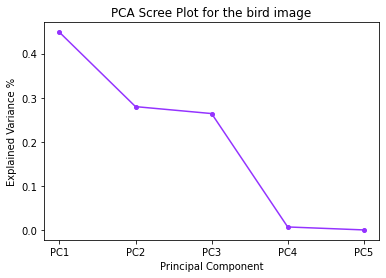

In [95]:
pc, varRatio = pcaCalc(birdSample)
print('PC1, PC2, and PC3 together account for', (varRatio[0] + varRatio[1] + varRatio[2]) * 100, '% of the variance, hence we select a 3D subspace')
plt.plot(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], varRatio, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('PCA Scree Plot for the bird image')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance %')
plt.show()
plt.close()

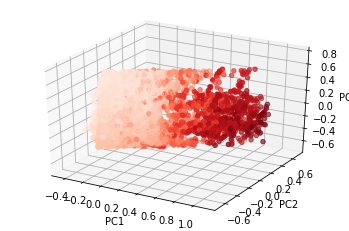

In [96]:
pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
ax = plt.axes(projection = '3d')
ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c = pc_df['PC1'], cmap = 'Reds')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()
plt.close()

PC1, PC2, and PC3 together account for 99.42030738438365 % of the variance, hence we select a 3D subspace


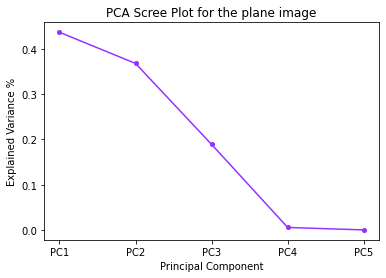

In [97]:
pc, varRatio = pcaCalc(planeSample)
print('PC1, PC2, and PC3 together account for', (varRatio[0] + varRatio[1] + varRatio[2]) * 100, '% of the variance, hence we select a 3D subspace')
plt.plot(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], varRatio, marker = 'o', markersize = '4', color = '#9433ff')
plt.title('PCA Scree Plot for the plane image')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance %')
plt.show()
plt.close()

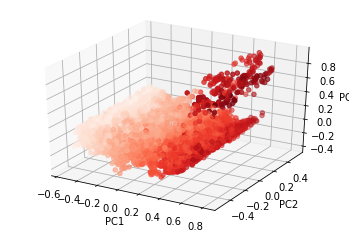

In [98]:
pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
ax = plt.axes(projection = '3d')
ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c = pc_df['PC1'], cmap = 'Reds')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()
plt.close()

t-SNE:

In [99]:
def tsneCalc(df, pplxty):
    dfEmbedded = manifold.TSNE(n_components = 2, perplexity = pplxty).fit_transform(df.values)
    return dfEmbedded

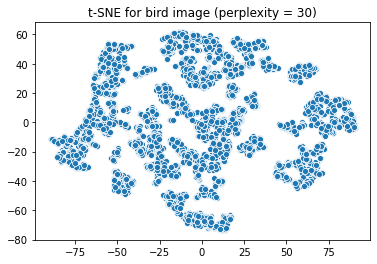

In [100]:
perpl = 30
birdTsne = tsneCalc(birdSample, perpl)
sns.scatterplot(birdTsne[:, 0], birdTsne[:, 1])
plt.title('t-SNE for bird image (perplexity = {})'.format(str(perpl)))
plt.show()
plt.close()

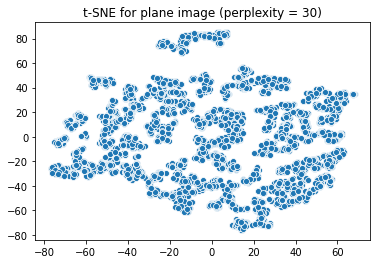

In [102]:
planeTsne = tsneCalc(planeSample, perpl)
sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1])
plt.title('t-SNE for plane image (perplexity = {})'.format(str(perpl)))
plt.show()
plt.close()

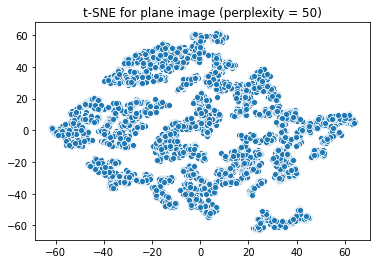

In [103]:
perpl = 50
planeTsne = tsneCalc(planeSample, perpl)
sns.scatterplot(planeTsne[:, 0], planeTsne[:, 1])
plt.title('t-SNE for plane image (perplexity = {})'.format(str(perpl)))
plt.show()
plt.close()